In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import gdown
from patsy import dmatrix

## Loading and cleaning

In [2]:
# Loading data from GDrive.

# Data with BDL merged,
file_id = "1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN"
url = f"https://drive.google.com/uc?id={file_id}"
file_extension = "downloaded_file.csv"
gdown.download(url, file_extension, quiet=False)
df = pd.read_csv(file_extension, sep=",")

Downloading...
From (original): https://drive.google.com/uc?id=1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN
From (redirected): https://drive.google.com/uc?id=1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN&confirm=t&uuid=bbc54aeb-6db4-4099-947b-d155352546b5
To: C:\Users\Konrad\Desktop\Magisterka\Kod\2024-mgr-sluzba-cywilna\Python\Code\downloaded_file.csv
100%|██████████| 254M/254M [00:09<00:00, 26.5MB/s] 


In [3]:
# Dropping data from 2017: too few records.
df = df[df['year'] > 2017]

# Dropping advertised_institution (too many nulls).
df.drop(['advertised_institution'], axis=1, inplace=True)

In [4]:
# Changing commas to dots in decimals.
df['unemployment'] = df['unemployment'].str.replace(",", ".", regex=False).astype(float)

In [5]:
# Changing "," to "." in numerical variables.
comma_cols_to_replace = {
    'mediana_wieku': 'bdl_age_median',
    'wydatki_powiat': 'bdl_district_expenses',
    'wynagrodzenia': 'bdl_average_salary'
}

# Replace commas with dots and convert to float.
for old_col, new_col in comma_cols_to_replace.items():
    try:
        df[new_col] = df[old_col].str.replace(',', '.', regex=False).astype(float)
    except AttributeError:
        df[new_col] = df[old_col]
        continue

df.drop(columns=comma_cols_to_replace.keys(), inplace=True)

In [6]:
# Other columns to rename.
col_names_to_replace = {
    'cena_mieszkan': 'bdl_avg_house_pricing',
    'saldo_migracji': 'bdl_migration_coefficient',
    'wsp_feminizacji': 'bdl_feminization_coefficient'
}

for old_col, new_col in col_names_to_replace.items():
    df[new_col] = df[old_col].astype(float)
    df.drop([old_col], axis=1, inplace=True)

In [7]:
df = df[df['work_time'] == 1]
df.drop(['work_time'], axis=1, inplace=True)

In [8]:
df = df[df['ad_views'].notnull()]

In [9]:
# We're not interested in these variables:
# - women_percentage, bdl_feminization_coefficient: low variability
# - bdl_district_expenses: too many nulls
# - applicants: that's what we're measuring, so adding that variable wouldn't make sense
df.drop(['women_percentage', 'bdl_feminization_coefficient', 'applicants', 'bdl_district_expenses'], axis=1, inplace=True)

## Imputation

In [10]:
# Imputing values for salary_for_position, since this variable has relatively low variance and is potentially of greater importance.
# However, imputing at institution-level won't solve the problem completely,
# since for some institutions, years or districts there was no data about salary at all.
# What is more, there was no salary data for średni szczebel zarządzania position category in the original data.
# Fortunately, that information was available here:
# https://dane.gov.pl/pl/dataset/1579/resource/56259,przecietne-wynagrodzenie-cakowite-wedug-grup-stanowisk-2023-r/table?page=1&per_page=20&q=&sort=
# For this reason, 6 imputations are needed (the sequence matters).

df_for_imputation_institution_level = df[df['salary_for_position'].notnull()]
df_for_imputation_district_level = df[df['salary_for_position'].notnull()]
df_for_imputation_voivodeship_level = df[df['salary_for_position'].notnull()]
df_for_imputation_year_level = df[df['salary_for_position'].notnull()]
df_for_imputation_category_level = df[df['salary_for_position'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_year'})
)

df_for_imputation_category_level = (
    df_for_imputation_category_level
    .groupby(['position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_category'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year', 'position_category'], how='left')
df = df.merge(df_for_imputation_category_level, on=['position_category'], how='left')

df['salary_for_position'] = df['salary_for_position'].fillna(df['median_institution'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_district'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_voivodeship'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_year'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_category'])

df = df.drop(columns=['median_institution', 'median_category', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

# Assigning mean salaries for sredni szczebel zarzadzania manually (from the mentioned link):
mean_sredni_szczebel_2023 = 13160
mean_sredni_szczebel_2022 = 11322
mean_sredni_szczebel_2021 = 10579
mean_sredni_szczebel_2020 = 12633
mean_sredni_szczebel_2019 = 11693
mean_sredni_szczebel_2018 = 11088

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2023),
    'salary_for_position'
] = mean_sredni_szczebel_2023

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2022),
    'salary_for_position'
] = mean_sredni_szczebel_2022

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2021),
    'salary_for_position'
] = mean_sredni_szczebel_2021

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2020),
    'salary_for_position'
] = mean_sredni_szczebel_2020

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2019),
    'salary_for_position'
] = mean_sredni_szczebel_2019

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2018),
    'salary_for_position'
] = mean_sredni_szczebel_2018

In [11]:
# Fluctuation

df_for_imputation_institution_level = df[df['fluctuation'].notnull()]
df_for_imputation_district_level = df[df['fluctuation'].notnull()]
df_for_imputation_voivodeship_level = df[df['fluctuation'].notnull()]
df_for_imputation_year_level = df[df['fluctuation'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_year'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year'], how='left')

df['fluctuation'] = df['salary_for_position'].fillna(df['median_institution'])
df['fluctuation'] = df['salary_for_position'].fillna(df['median_district'])
df['fluctuation'] = df['salary_for_position'].fillna(df['median_voivodeship'])
df['fluctuation'] = df['salary_for_position'].fillna(df['median_year'])

df = df.drop(columns=['median_institution', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

In [12]:
# Employment contract

df_for_imputation_institution_level = df[df['employment_contract'].notnull()]
df_for_imputation_district_level = df[df['employment_contract'].notnull()]
df_for_imputation_voivodeship_level = df[df['employment_contract'].notnull()]
df_for_imputation_year_level = df[df['employment_contract'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_year'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year'], how='left')

df['employment_contract'] = df['employment_contract'].fillna(df['median_institution'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_district'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_voivodeship'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_year'])

df = df.drop(columns=['median_institution', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

## Feature engineering

In [13]:
df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)
df['offer_salary_mentioned'] = df['offer_salary'].notna().astype(int)
df.drop(['offer_salary'], axis=1, inplace=True)

C:\Users\Konrad\AppData\Local\Temp\ipykernel_10916\1148810047.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)


In [14]:
df['len_requirements'] = df['requirements'].str.count(r'\|-\|')
df['len_nice_to_have'] = df['nice_to_have'].str.count(r'\|-\|')
df['len_responsibilities'] = df['responsibilities'].str.count(r'\|-\|')

# null for nice-to-have means no nice-to-have.
df.loc[df['len_nice_to_have'].isnull(), 'len_nice_to_have'] = 0

df.drop(['requirements', 'nice_to_have', 'responsibilities'], axis=1, inplace=True)

## Analyses

##### Correlation

In [15]:
from scipy import stats
# Variable correlation.

# From scipy documentation:
# "Calculates a point biserial correlation coefficient and the associated p-value.
# The point biserial correlation is used to measure the relationship between a binary variable, x, and a continuous variable, y. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship".

numerical_columns = [
    'ad_views',
    'offer_salary_mentioned',
    'salary_for_position',
    'fluctuation',
    'employment_contract',
    'bdl_avg_house_pricing',
    'bdl_age_median',
    'bdl_migration_coefficient',
    'bdl_average_salary',
    'vacancies',
    'len_requirements',
    'len_nice_to_have',
    'len_responsibilities'
]

correlation_results = {}
for col in numerical_columns:
    x = df['result']
    y = df[col]
    valid = x.notna() & y.notna()
    r, p = stats.pointbiserialr(x[valid], y[valid])
    correlation_results[col] = {
        'correlation': r,
        'is_statistically_significant': int(p <= 0.05)
    }

correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index')
correlation_df = correlation_df.sort_values(by='is_statistically_significant', ascending=False)

print(correlation_df)

                           correlation  is_statistically_significant
ad_views                      0.231427                             1
offer_salary_mentioned        0.064624                             1
salary_for_position          -0.113068                             1
fluctuation                  -0.113068                             1
employment_contract           0.017761                             1
bdl_avg_house_pricing        -0.081331                             1
bdl_age_median                0.013534                             1
bdl_migration_coefficient    -0.050769                             1
bdl_average_salary           -0.088522                             1
vacancies                     0.068625                             1
len_requirements             -0.096059                             1
len_nice_to_have             -0.023733                             1
len_responsibilities         -0.104691                             1


In [16]:
df[numerical_columns].describe()

,ad_views,offer_salary_mentioned,salary_for_position,fluctuation,employment_contract,bdl_avg_house_pricing,bdl_age_median,bdl_migration_coefficient,bdl_average_salary,vacancies,len_requirements,len_nice_to_have,len_responsibilities
count,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000
mean,2067.338047,0.271731,6041.427301,6041.427301,577.759261,7123.717628,41.950353,2811.867024,6412.095721,1.118419,7.732663,3.258871,5.366524
std,843.645392,0.444854,1650.320724,1650.320724,657.441935,2939.196058,1.780767,4011.859714,1509.840859,0.459370,3.085298,2.496036,2.230622
min,124.000000,0.000000,990.833333,990.833333,0.050000,0.000000,34.600000,-1065.000000,3183.340000,1.000000,2.000000,0.000000,0.000000
25%,1337.000000,0.000000,4840.697276,4840.697276,18.300000,4743.000000,40.700000,-171.000000,5252.170000,1.000000,6.000000,1.000000,4.000000
50%,2146.000000,0.000000,5833.339921,5833.339921,284.850000,6656.000000,41.500000,189.000000,6432.780000,1.000000,7.000000,3.000000,5.000000
75%,2622.000000,1.000000,6831.692744,6831.692744,820.250000,9129.000000,43.300000,6224.000000,7391.950000,1.000000,9.000000,5.000000,7.000000
max,11725.000000,1.000000,22911.326995,22911.326995,3271.880000,15717.000000,48.900000,11727.000000,12804.030000,5.000000,31.000000,23.000000,32.000000


##### Bar charts

In [17]:
def plot_ibcs_bar_chart(df: pd.DataFrame, group_col: str):

    group_means = df.groupby(group_col)['result'].mean().reset_index()
    group_means.sort_values(by='result', ascending=False, inplace=True)

    ibcs_palette = ['#000000', '#444444', '#777777', '#AAAAAA', '#DDDDDD']
    sns.set(style='whitegrid')
    
    plt.figure(figsize=(15, 7))
    ax = sns.barplot(
        x=group_col, 
        y='result', 
        data=group_means, 
        palette=ibcs_palette[:len(group_means)],
        edgecolor='black'
    )

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=13, fontweight='bold')

    ax.set_title(f"Mean result by {group_col}", fontsize=14, weight='bold')
    ax.set_ylabel("Mean result", fontsize=12)
    ax.set_xlabel(group_col, fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    sns.despine()
    
    plt.tight_layout()
    plt.show()

C:\Users\Konrad\AppData\Local\Temp\ipykernel_10916\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


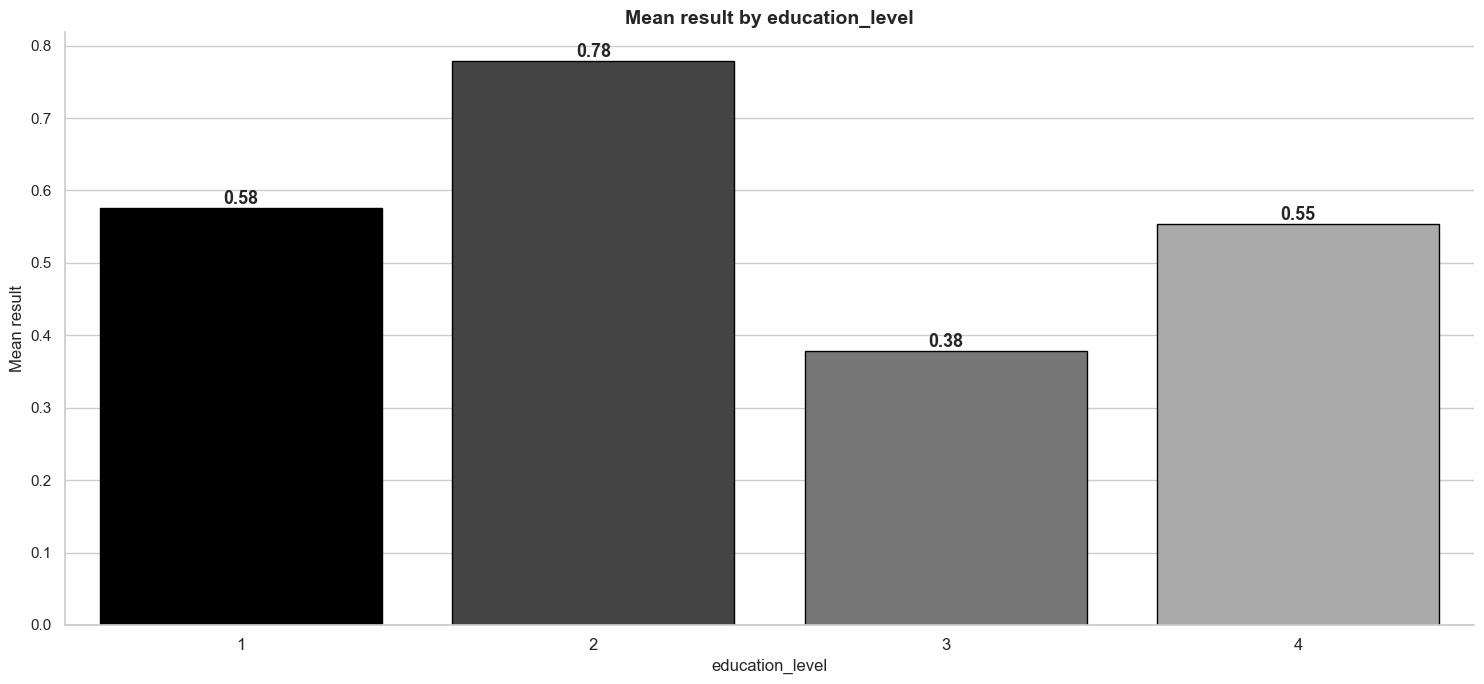

C:\Users\Konrad\AppData\Local\Temp\ipykernel_10916\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\Konrad\AppData\Local\Temp\ipykernel_10916\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


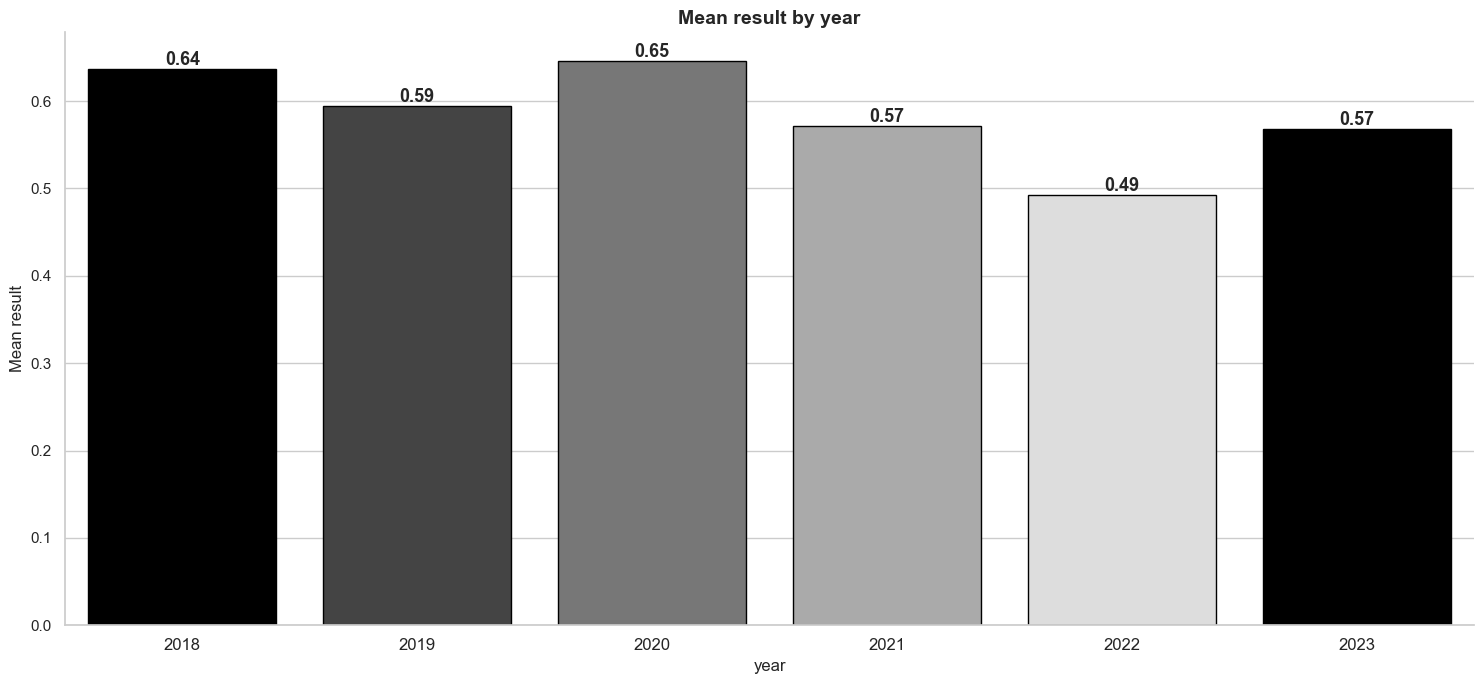

C:\Users\Konrad\AppData\Local\Temp\ipykernel_10916\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\Konrad\AppData\Local\Temp\ipykernel_10916\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


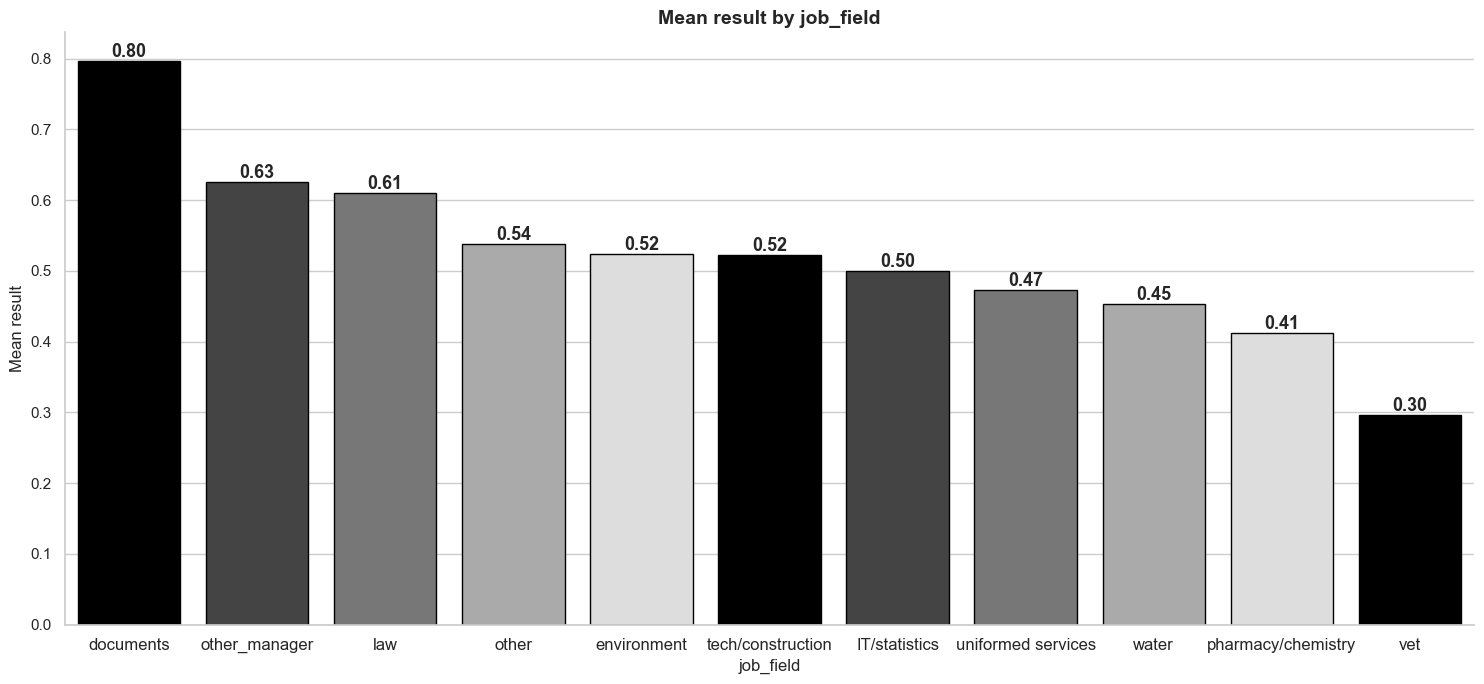

C:\Users\Konrad\AppData\Local\Temp\ipykernel_10916\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\Konrad\AppData\Local\Temp\ipykernel_10916\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


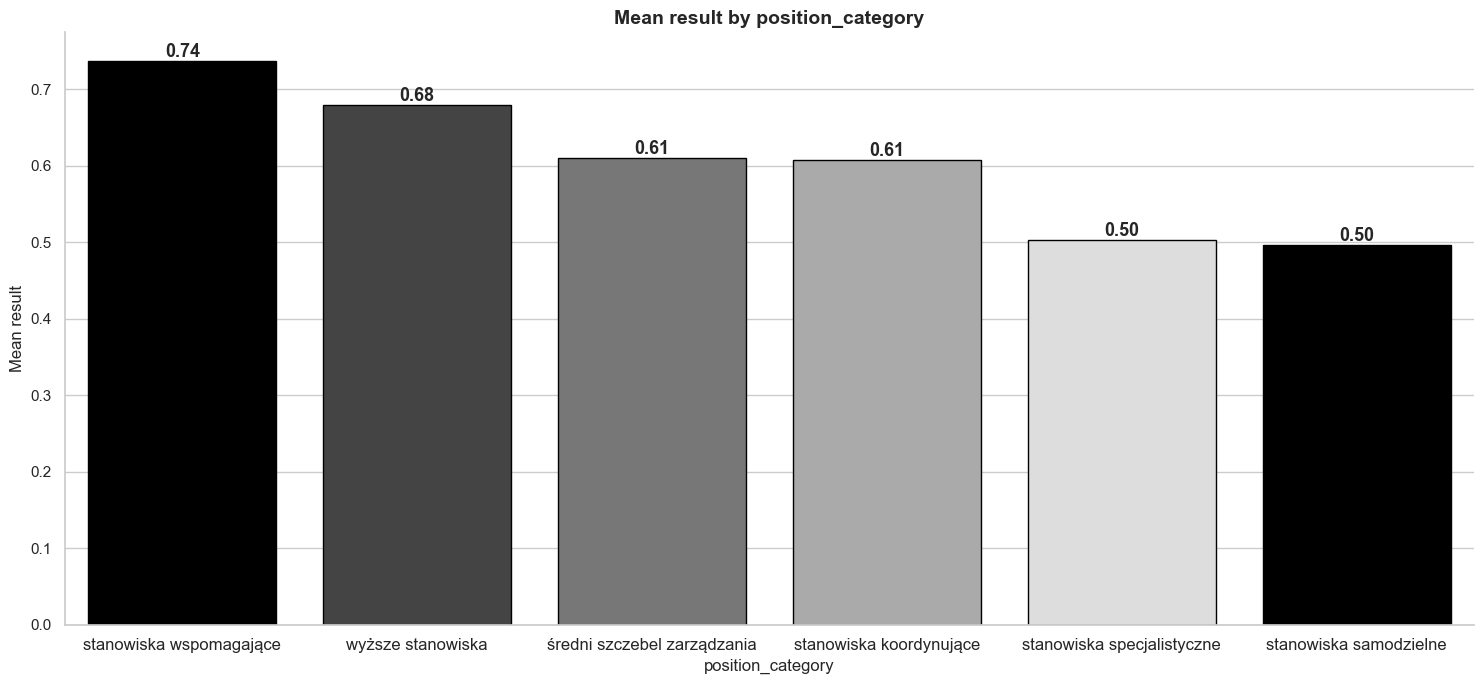

In [18]:
plot_bar_columns = [
    'education_level',
    'year',
    'job_field',
    'position_category'
]

for column in plot_bar_columns:
    plot_ibcs_bar_chart(df, column)

##### Time series

In [19]:
# Dropping cols unnecessary for statistical analyses.
string_cols_for_temporary_dropping = [
    'ad_id',
    'institution_address',
    'workplace',
    'department',
    'date_announced',
    'institution_address',
    'workplace',
    'department',
    'city',
    'position',
    'vacancies'
]

df_for_charts = df.drop(string_cols_for_temporary_dropping, axis=1)
df_for_charts["voivodeship_district"] = df_for_charts['voivodeship'].astype(str) + df_for_charts['district'].astype(str)

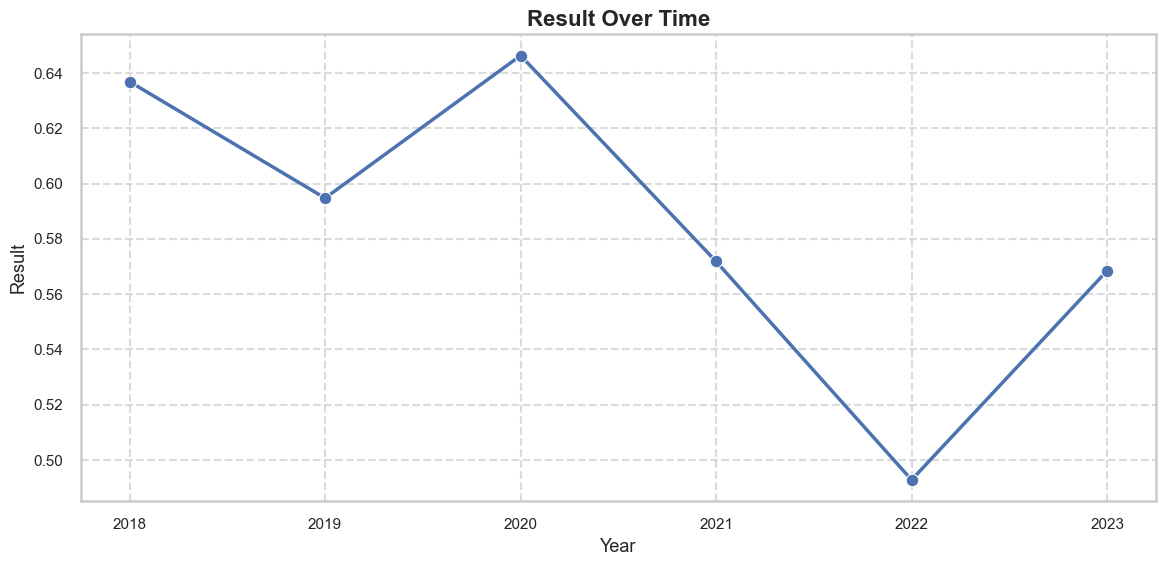

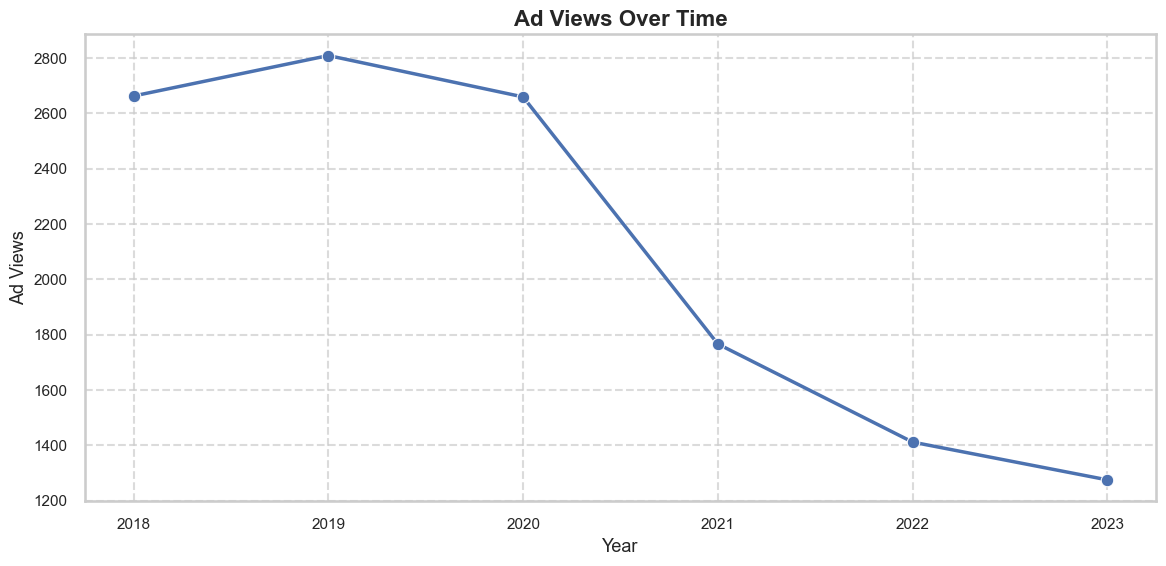

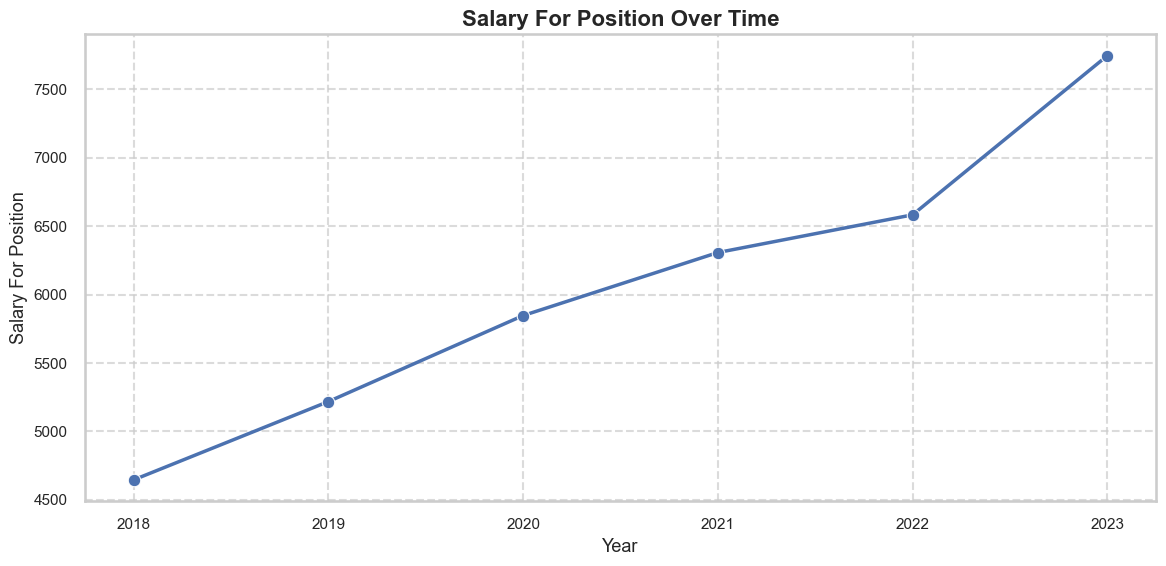

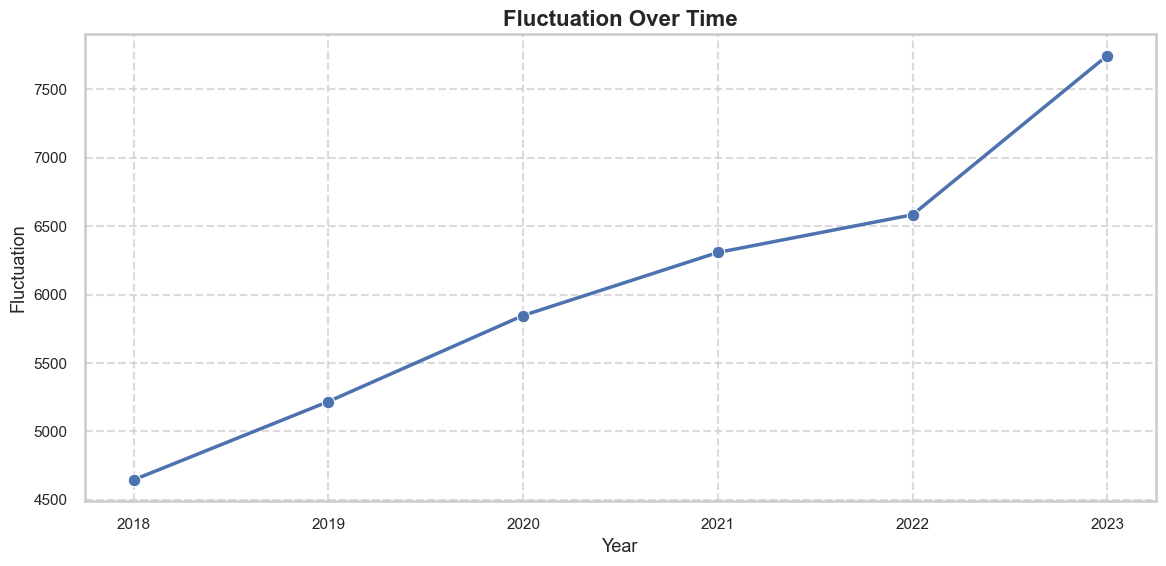

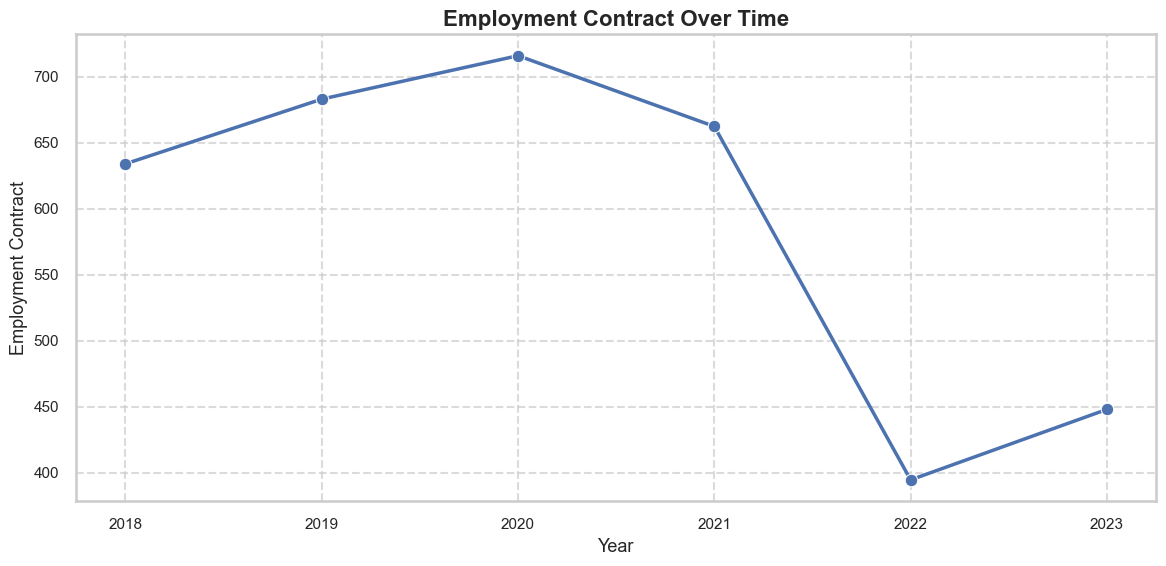

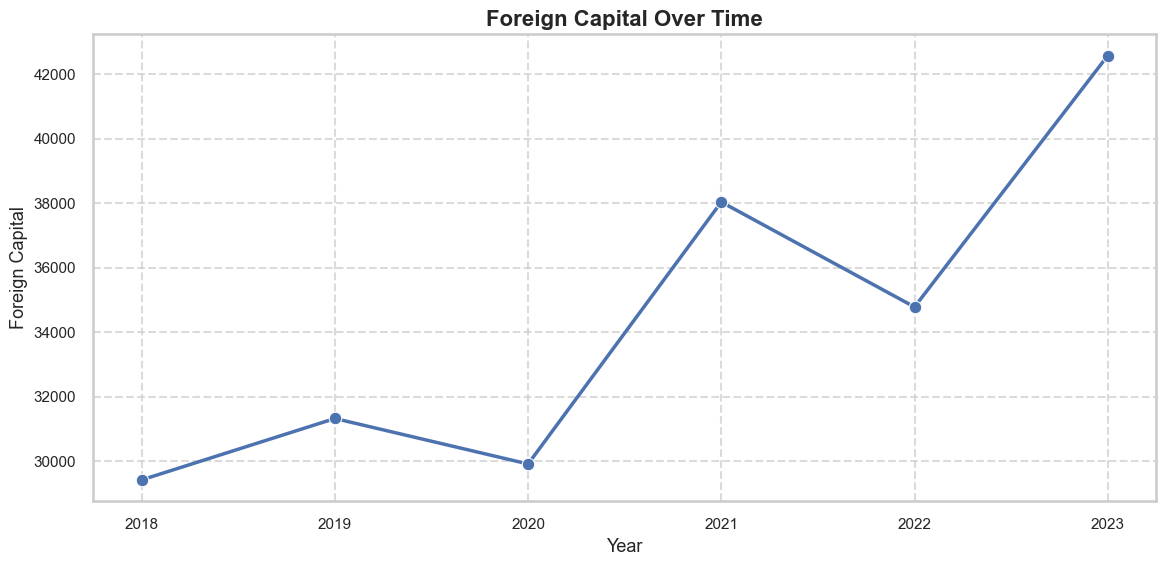

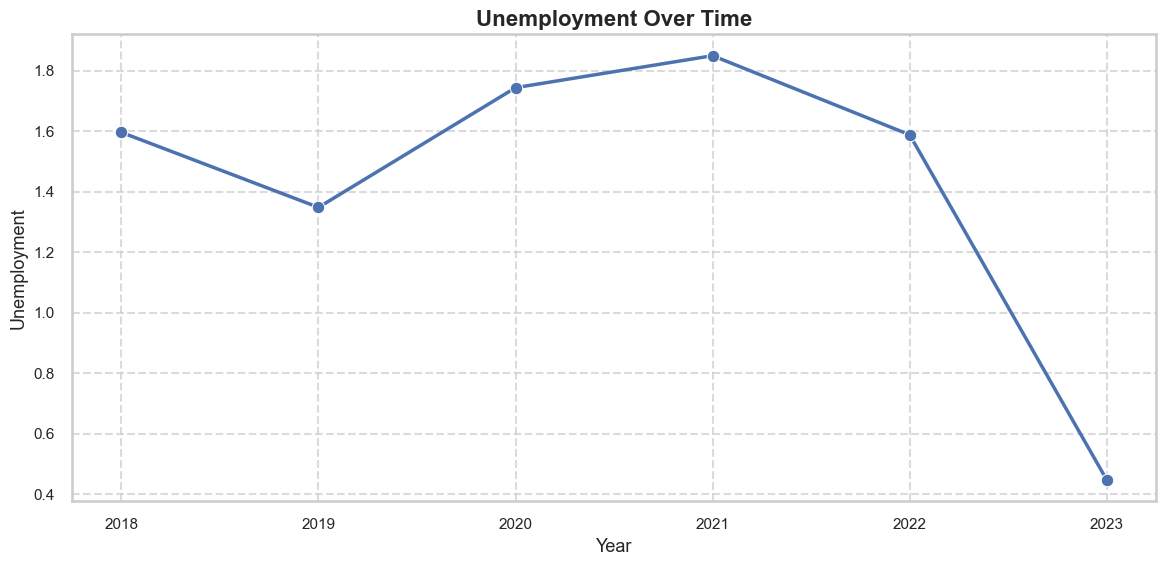

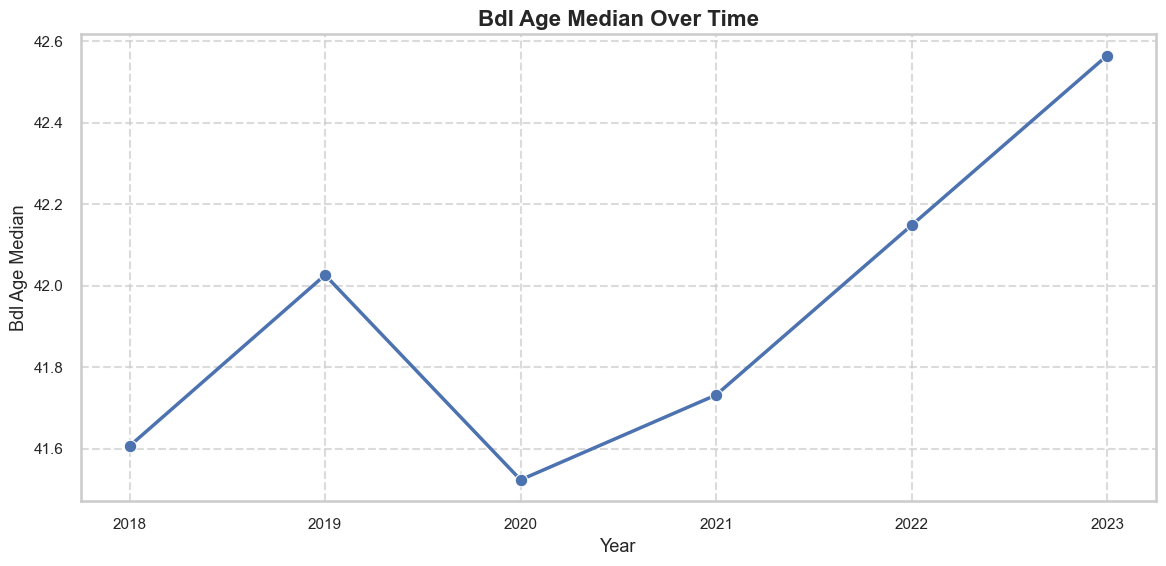

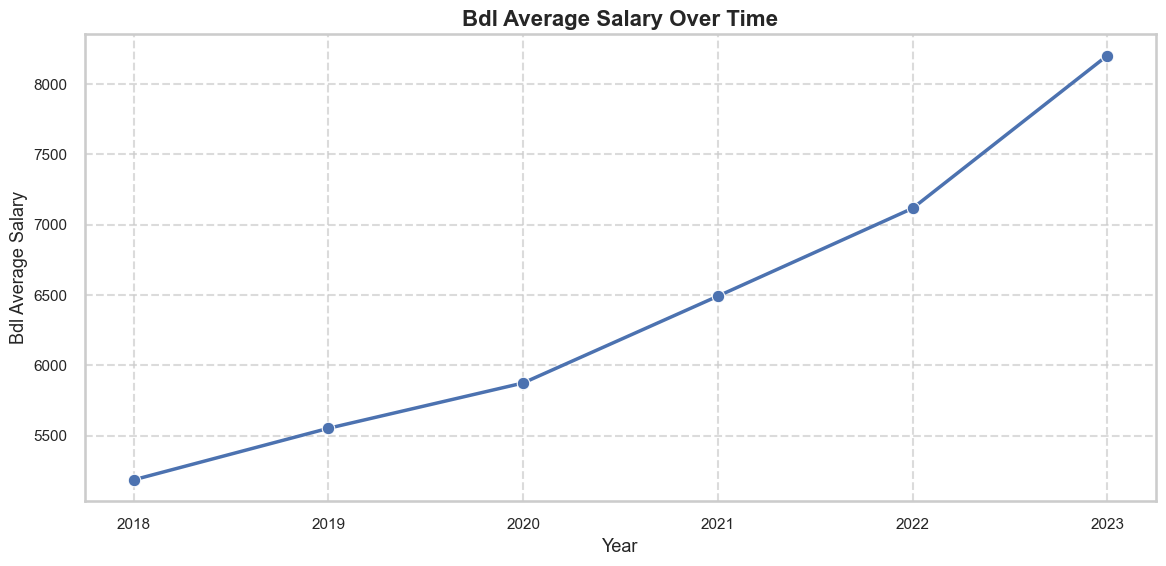

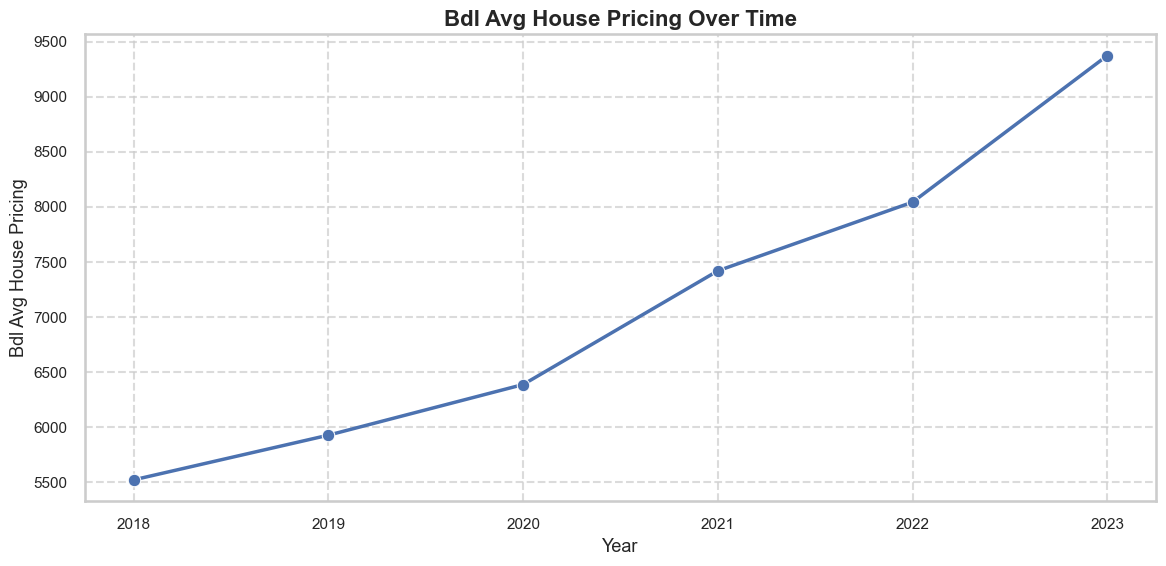

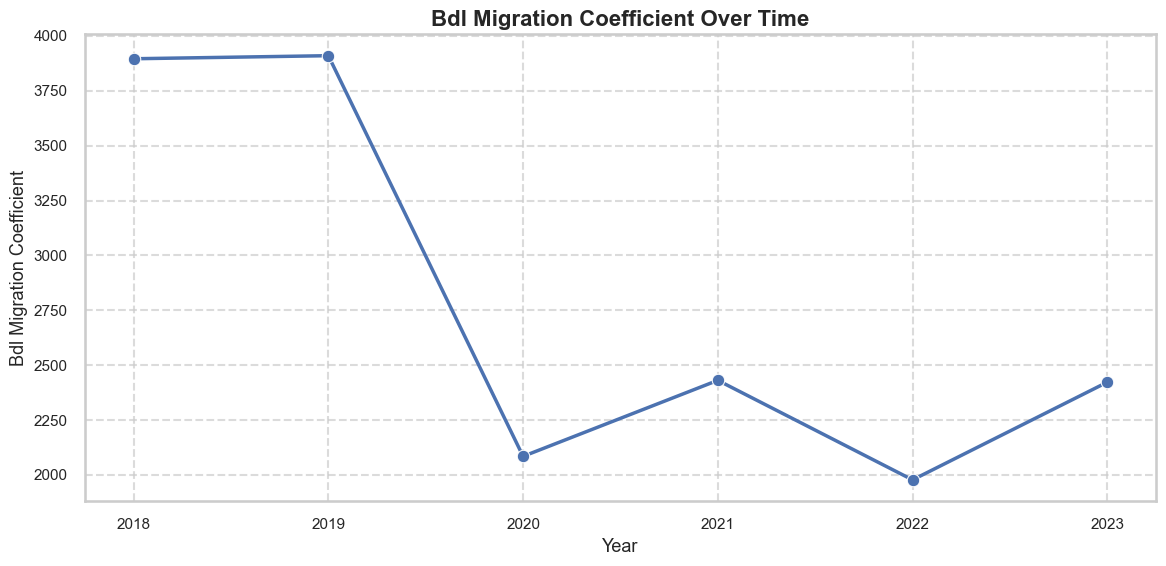

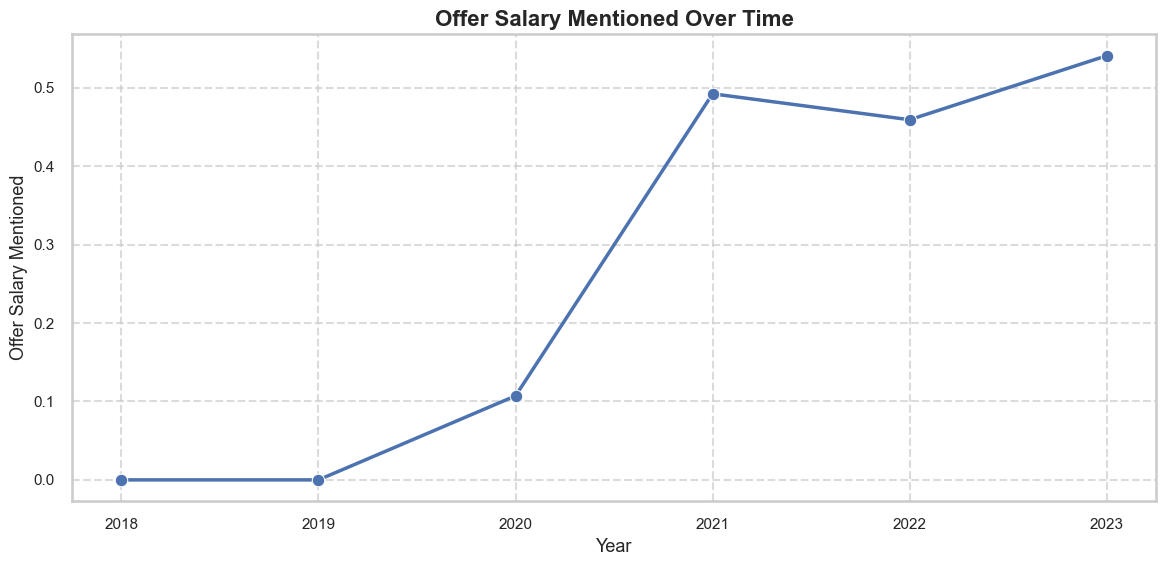

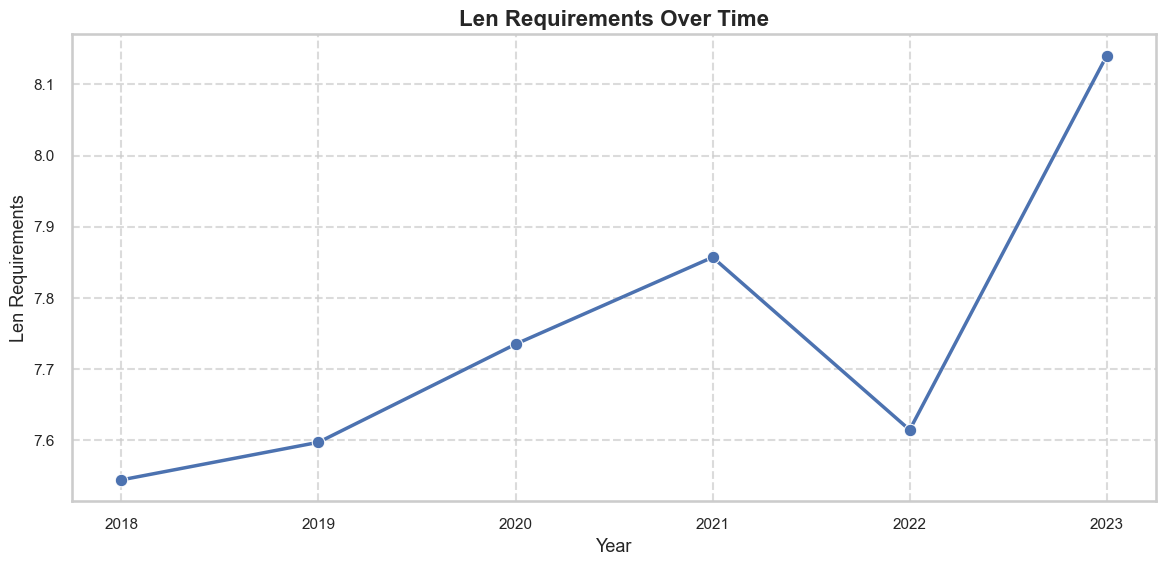

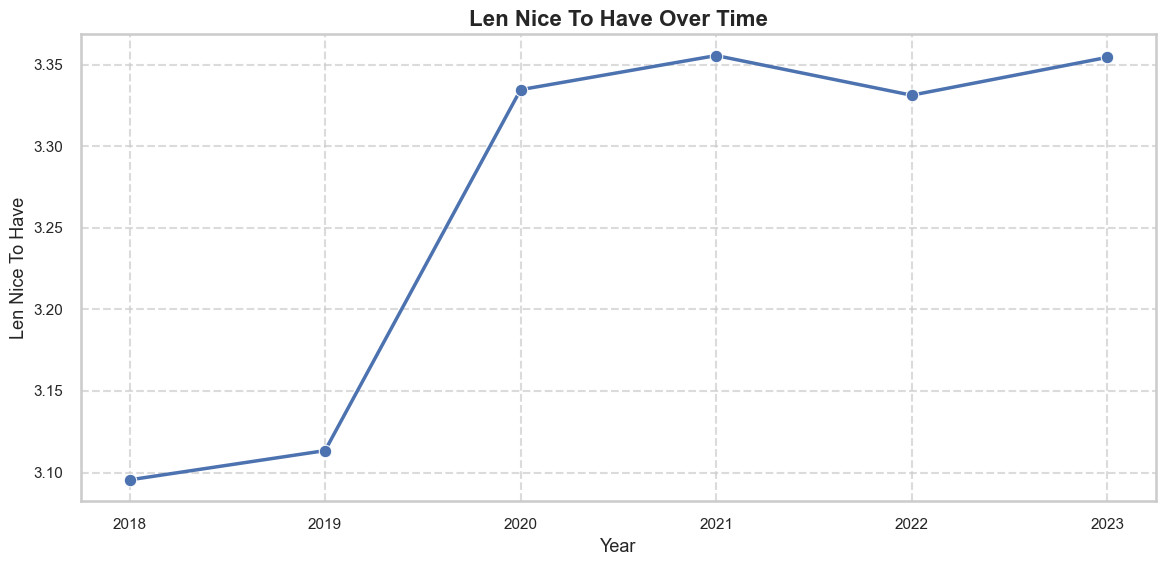

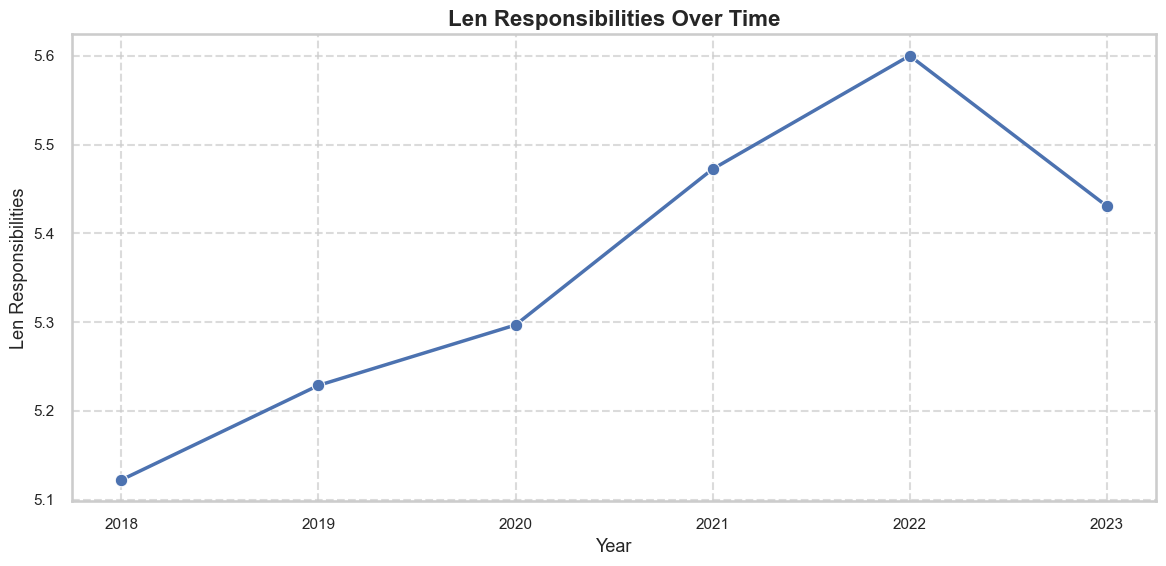

In [20]:
def plot_individual_time_series(dataframe):
    exclude_columns = ['voivodeship', 'district', 'education_level', 'work_time', 'institution']
    df_grouped = dataframe.groupby('year').mean(numeric_only=True)
    columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]

    sns.set(style="whitegrid", context="talk", palette="deep")

    for column in columns_to_plot:
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o', linewidth=2.5)
        plt.title(f"{column.replace('_', ' ').title()} Over Time", fontsize=16, weight='bold')
        plt.xlabel("Year", fontsize=13)
        plt.ylabel(column.replace('_', ' ').title(), fontsize=13)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        plt.grid(visible=True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

plot_individual_time_series(df_for_charts)

##### Variability charts

In [21]:
# def plot_variability(dataframe):
#     exclude_columns = ['work_time', 'year', 'district', 'voivodeship', 'institution']
#     df_grouped = dataframe.groupby('district').mean(numeric_only=True)
#     columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]
# 
#     sns.set(style="whitegrid", context="talk", palette="deep")
# 
#     for column in columns_to_plot:
#         plt.figure(figsize=(12, 6))
#         sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o', linewidth=2.5)
#         plt.title(f"{column.replace('_', ' ').title()} District Variability", fontsize=16, weight='bold')
#         plt.xlabel("District", fontsize=13)
#         plt.ylabel(column.replace('_', ' ').title(), fontsize=13)
#         plt.xticks(rotation=45, fontsize=11)
#         plt.yticks(fontsize=11)
#         plt.grid(visible=True, linestyle='--', alpha=0.7)
#         plt.tight_layout()
#         plt.show()
# 
# plot_variability(df_for_charts)

##### Spaghetti plots

In [22]:
df_for_charts_district_agg = df_for_charts.groupby(by=['voivodeship_district', 'year'])['result'].mean()
df_for_charts_institution_agg = df_for_charts.groupby(by=['institution', 'year'])['result'].mean()

In [23]:
def plot_spaghetti_chart(df_grouped, group_cols):
    df = df_grouped.reset_index()
    
    groups = df.groupby(group_cols)

    plt.figure(figsize=(10, 6))
    for group_vals, group_data in groups:
        label = '-'.join(map(str, group_vals)) if isinstance(group_vals, tuple) else str(group_vals)
        plt.plot(group_data['year'], group_data['result'], label=label)

    plt.xlabel('Year')
    plt.ylabel('Result')
    plt.title('Spaghetti Chart')
    plt.tight_layout()
    plt.show()

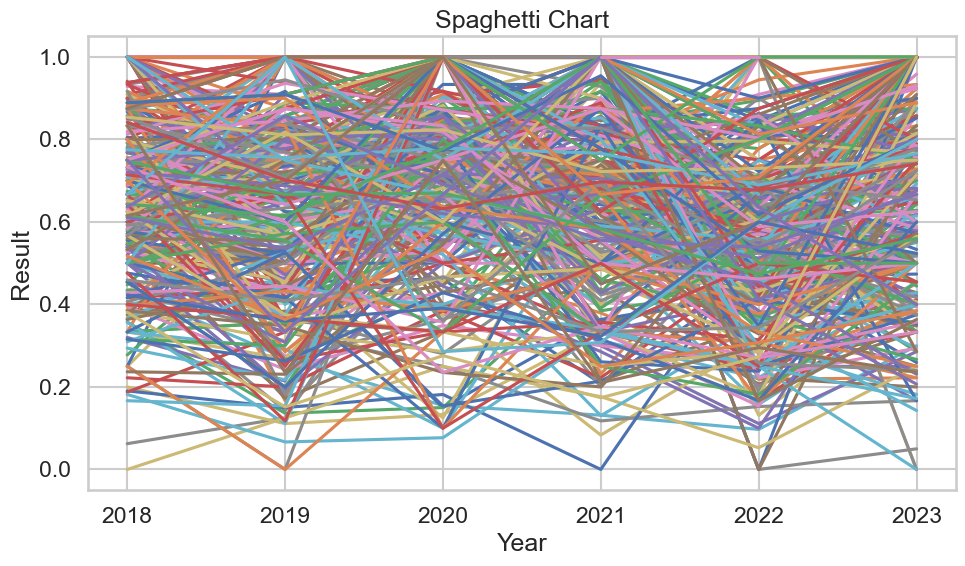

In [24]:
plot_spaghetti_chart(df_for_charts_district_agg, ['voivodeship_district'])

In [25]:
# plot_spaghetti_chart(df_for_charts_institution_agg, ['institution'])

## Feature importance

In [26]:
# bdl_avg_salary, salary_for_position, and bdl_housing are correlated with each other.
df['relative_salary'] = df['salary_for_position'] / df['bdl_average_salary']
df.drop(['salary_for_position', 'bdl_average_salary', 'bdl_avg_house_pricing'], axis=1, inplace=True)

##### Preparing data for logistic regression

In [27]:
# Dealing with categorical columns with the use of USM method
# (an alternative to 1hot encoding in which each category is represented by coefficients that sum to zero).

education_matrix = dmatrix('C(education_level, Sum)', df, return_type='dataframe').iloc[:, 1:]
df = pd.concat([df.drop('education_level', axis=1), education_matrix], axis=1)

position_matrix = dmatrix('C(position_category, Sum)', df, return_type='dataframe').iloc[:, 1:]
job_field_matrix = dmatrix('C(job_field, Sum)', df, return_type='dataframe').iloc[:, 1:]

df = pd.concat([df.drop(['position_category', 'job_field'], axis=1), position_matrix, job_field_matrix], axis=1)

In [28]:
df_model = df.drop(string_cols_for_temporary_dropping, axis=1)
df_model['voivodeship_district'] = df_model['voivodeship'].astype(str) + df_model['district'].astype(str)
df_model.drop(['voivodeship', 'district'], axis=1, inplace=True)

In [29]:
# Excluding institutions that posted less than 10 job ads

# Calculate the frequency of each institution.
institution_counts = df_model['institution'].value_counts()

# Identify institutions to exclude.
institutions_to_exclude = institution_counts[institution_counts < 10].index

# Filter df_model to keep only institutions that appear 10 or more times.
df_model = df_model[~df_model['institution'].isin(institutions_to_exclude)]

In [30]:
# Excluding institutions that are 0- or 1-inflated.
institutions_inflated = []
for institution, group in df_model.groupby('institution'):
    unique_results = group['result'].unique()
    if len(unique_results) == 1 and (unique_results[0] == 0 or unique_results[0] == 1):
        institutions_inflated.append(institution)

df_model = df_model[~df_model['institution'].isin(institutions_inflated)]

In [31]:
# Making year a categorical col
df_model['year_2022'] = (df_model['year'] == 2022).astype(int)
df_model['year_before_2020'] = (df_model['year'] <= 2020).astype(int)
df_model.drop(['year'], axis=1, inplace=True)

In [32]:
# # Log transformations before performing standardization.
# variables_to_plot = ['ad_views', 'relative_salary', 'fluctuation', 'employment_contract', 'foreign_capital', 'unemployment', 'bdl_age_median', 'bdl_migration_coefficient']
# 
# for column in variables_to_plot:
#     plt.figure(figsize=(10, 6))
#     sns.histplot(df_model[column], kde=True)
#     plt.title(f'Distribution of {column}')
#     plt.xlabel(column)
#     plt.ylabel('Frequency')
#     plt.tight_layout()
#     plt.show()

In [33]:
variables_to_log_transform = ['ad_views', 'relative_salary', 'foreign_capital', 'fluctuation', 'employment_contract']
for col in variables_to_log_transform:
    df_model[col] = np.log1p(df_model[col])

In [34]:
# I'm using cuberoot transformation for the migration coefficient, since it contains negative values.
df_model['bdl_migration_coefficient'] = np.cbrt(df_model['bdl_migration_coefficient'])

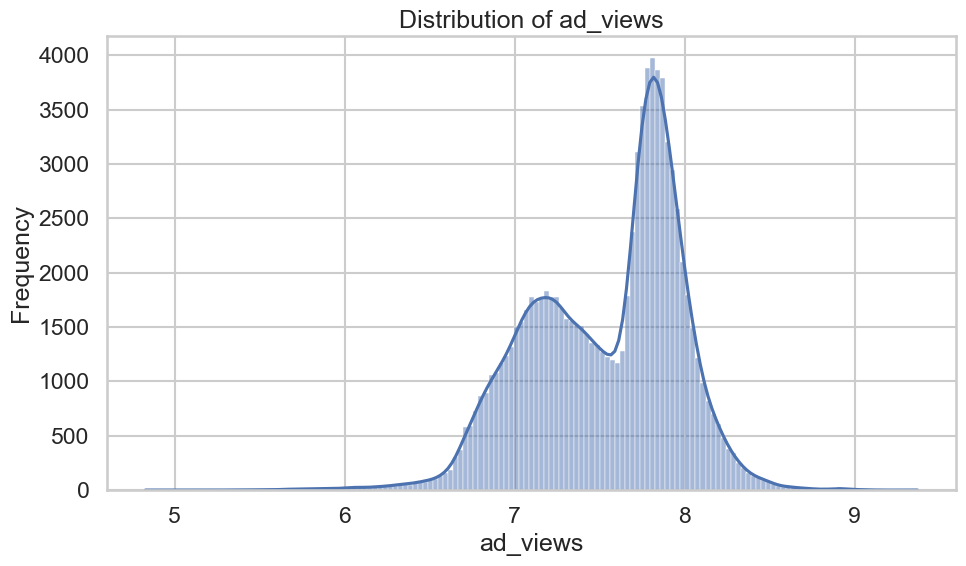

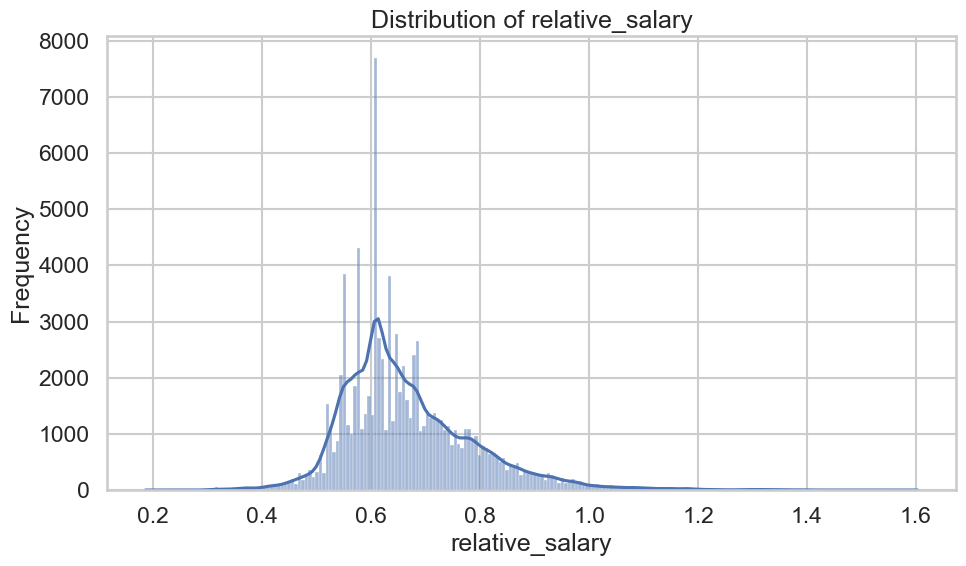

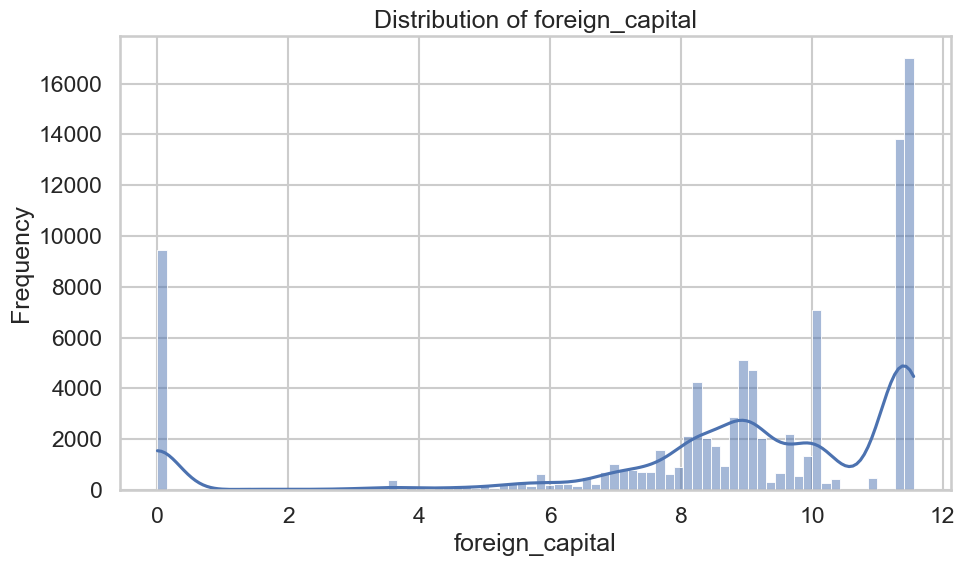

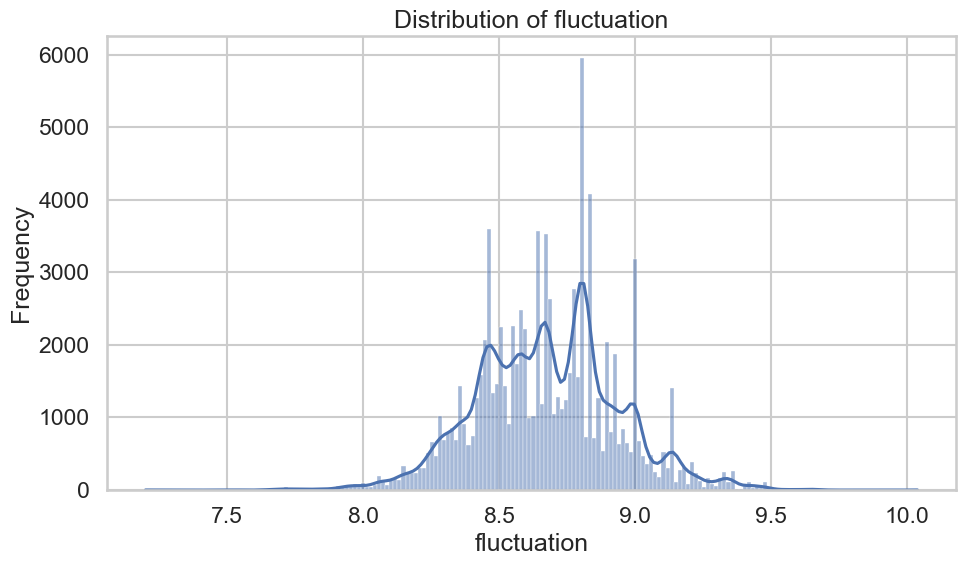

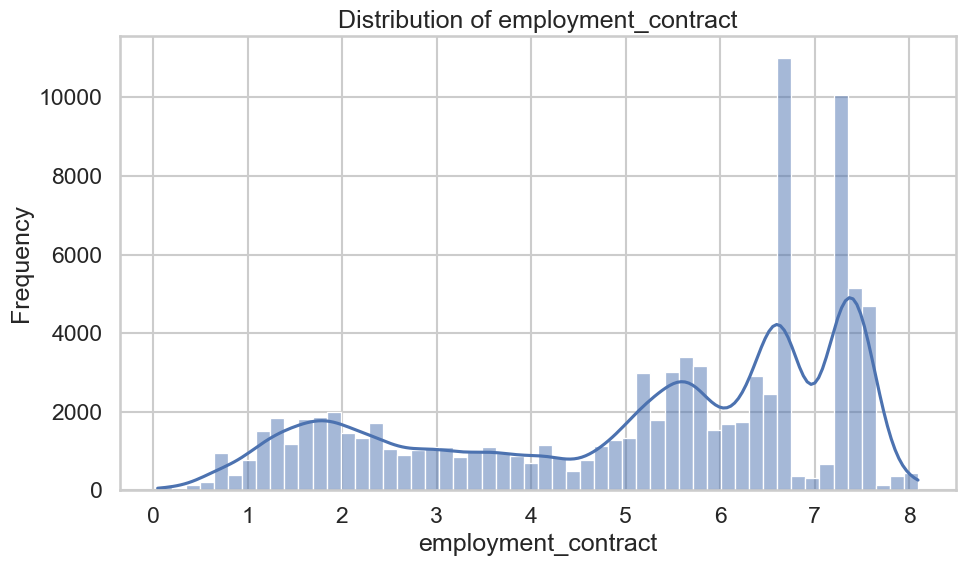

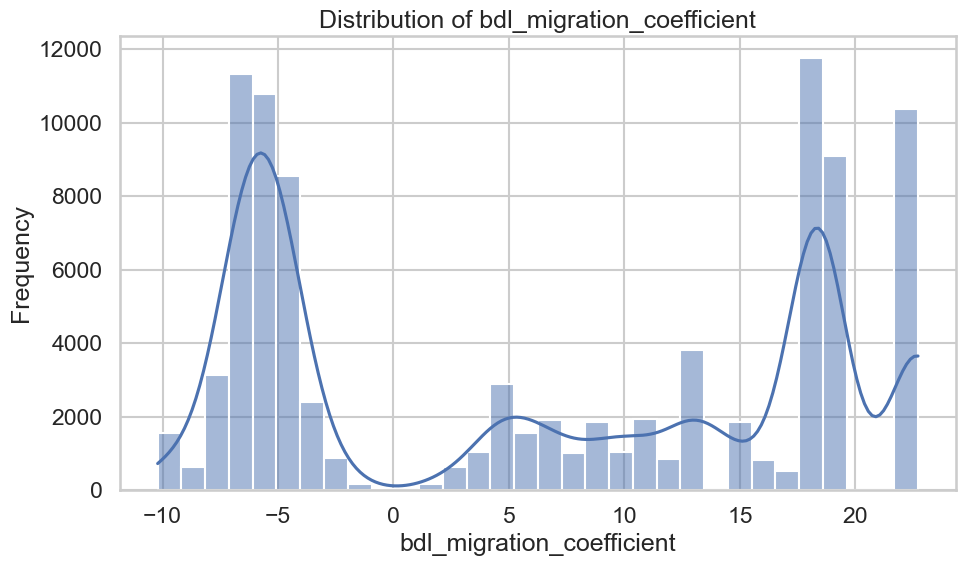

In [35]:
# Plotting distributions after transformation.
transformed_variables_to_plot = ['ad_views', 'relative_salary', 'foreign_capital', 'fluctuation', 'employment_contract', 'bdl_migration_coefficient']

for column in transformed_variables_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_model[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [36]:
from sklearn.model_selection import train_test_split

# Stratified train-test split (90% train, 10% test) based on an institution.
df_train, df_test = train_test_split(
    df_model,
    test_size=0.1,
    stratify=df_model['institution'],
    random_state=42
)

In [37]:
# Standarization.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Excluding categorical cols.
position_category_cols = df_train.filter(regex=r'^position_category').columns.tolist()
job_field_cols = df_train.filter(regex=r'^job_field').columns.tolist()
cols_to_exclude_from_standarization = ['result', 'institution', 'voivodeship_district', 'year_2022', 'year_before_2020'] + position_category_cols + job_field_cols

X_train_features = df_train.drop(cols_to_exclude_from_standarization, axis=1)
scaler.fit(X_train_features)
X_train_scaled = scaler.transform(X_train_features)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_features.columns, index=X_train_features.index)
X_train_scaled_df = pd.concat([X_train_scaled_df, df_train[cols_to_exclude_from_standarization]], axis=1)

In [38]:
# Standardizing the test set (with the scaler fitted on the training data).
X_test_features = df_test.drop(cols_to_exclude_from_standarization, axis=1)
X_test_scaled = scaler.transform(X_test_features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_features.columns, index=X_test_features.index)
X_test_scaled_df = pd.concat([X_test_scaled_df, df_test[cols_to_exclude_from_standarization]], axis=1)

In [39]:
institution_matrix_train = dmatrix('C(institution, Sum)', df_model, return_type='dataframe').iloc[:, 1:]
district_matrix_train = dmatrix('C(voivodeship_district, Sum)', df_model, return_type='dataframe').iloc[:, 1:]

df_model_institutions = pd.concat([df_model.drop(['institution', 'voivodeship_district'], axis=1), institution_matrix_train], axis=1)
df_model_districts = pd.concat([df_model.drop(['institution', 'voivodeship_district'], axis=1), district_matrix_train], axis=1)

df_model = X_train_scaled_df
df_model_institutions = df_model_institutions.loc[df_model.index]
df_model_districts = df_model_districts.loc[df_model.index]

df_test = X_test_scaled_df
institution_matrix_test = dmatrix('C(institution, Sum)', df_test, return_type='dataframe').iloc[:, 1:]
district_matrix_test = dmatrix('C(voivodeship_district, Sum)', df_test, return_type='dataframe').iloc[:, 1:]

df_test_institutions = pd.concat([df_test.drop(['institution', 'voivodeship_district'], axis=1), institution_matrix_test], axis=1)
df_test_districts = pd.concat([df_test.drop(['institution', 'voivodeship_district'], axis=1), district_matrix_test], axis=1)

df_model.drop(['institution', 'voivodeship_district'], axis=1, inplace=True)
df_test.drop(['institution', 'voivodeship_district'], axis=1, inplace=True)

##### Applying logistic regression

In [40]:
# Function grouping together 1hot encoded categorical variables for dalex's Explainer.
def create_variable_groups(encoded_df, original_categorical_cols):
    dalex_variable_groups = {}

    for cat_col in original_categorical_cols:
        # Find all dummy columns for this categorical variable
        dummy_cols = [col for col in encoded_df.columns
                     if col.startswith(f'{cat_col}_')]

        if dummy_cols:
            dalex_variable_groups[cat_col] = dummy_cols

    return dalex_variable_groups

In [45]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import dalex as dx
import warnings

def log_regression(train_set, test_set, penalty, solver, cv, original_categorical_cols:list):
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    np.random.seed(42)

    X_train = train_set.drop('result', axis=1)
    y_train = train_set['result']
    X_test = test_set.drop('result', axis=1)
    y_test = test_set['result']

    model = LogisticRegression(penalty=penalty, solver=solver, random_state=42, max_iter=5000)

    param_grid = {
        'C': np.logspace(-4, 2, 7)
    }

    print("\nGridSearchCV")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    optimal_C = grid_search.best_params_['C']
    best_logistic_model = grid_search.best_estimator_

    print(f"\nOptimal C found: {optimal_C}")
    print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")

    print("\nInitializing DALEX Explainer")

    explainer = dx.Explainer(
        model = best_logistic_model,
        data = X_train,
        y = y_train,
        verbose=False,
        label=f"Logistic Regression (Optimal C={optimal_C:.4f}, Penalty={penalty})"
    )

    print("Calculating DALEX Feature Importance")
    dalex_variable_groups = create_variable_groups(X_train, original_categorical_cols)
    fi = explainer.model_parts(variable_groups = dalex_variable_groups)

    print("\nDALEX Feature Importance (Global)\n")
    print(fi.result)

    # Feature importance plot.
    fi.plot()

    # Ocena modelu na zbiorze testowym.
    y_pred_proba_test = best_logistic_model.predict_proba(X_test)[:, 1] # klasa pozytywna
    test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    print(f"ROC AUC na zbiorze testowym: {test_roc_auc:.4f}")
    return fi.result

In [46]:
# Feature importance without institutions and districts.
fi_result = log_regression(
    df_model,
    df_test,
    penalty='l1',
    solver='liblinear',
    cv=10,
    original_categorical_cols = ['job_field', 'position_category', 'education_level', 'voivodeship_district']
)
print(fi_result)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Optimal C found: 0.1
Best cross-validation ROC AUC: 0.7460

Initializing DALEX Explainer
Calculating DALEX Feature Importance

DALEX Feature Importance (Global)

       variable  dropout_loss               label
0  _full_model_      0.247682  LogisticRegression
1    _baseline_      0.503521  LogisticRegression


ValueError: label must be unique for each model

In [179]:
# Feature importance including 1hot encoded institutions.
fi_result_institutions = log_regression(
    df_model_institutions,
    df_test_institutions,
    penalty='l2',
    solver='liblinear',
    cv=10,
    original_categorical_cols = ['job_field', 'position_category', 'education_level', 'institution']
)
print(fi_result_institutions)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Optimal C found: 10.0
Best cross-validation ROC AUC: 0.7733

Initializing DALEX Explainer
Calculating DALEX Feature Importance

DALEX Feature Importance (Global)

                                              variable  dropout_loss  \
0    institution_Powiatowy Inspektorat Weterynarii ...      0.208293   
1    institution_Powiatowy Inspektorat Nadzoru Budo...      0.208354   
2    institution_Główny Inspektorat Jakości Handlow...      0.208375   
3    institution_Powiatowy Inspektorat Weterynarii ...      0.208402   
4    institution_Powiatowy Inspektorat Weterynarii ...      0.208429   
..                                                 ...           ...   
857                                      job_field_vet      0.219840   
858                                   year_before_2020      0.227240   
859                                  education_level_2      0.229511   
860                                      

ROC AUC na zbiorze testowym: 0.7758
                                              variable  dropout_loss  \
0    institution_Powiatowy Inspektorat Weterynarii ...      0.208293   
1    institution_Powiatowy Inspektorat Nadzoru Budo...      0.208354   
2    institution_Główny Inspektorat Jakości Handlow...      0.208375   
3    institution_Powiatowy Inspektorat Weterynarii ...      0.208402   
4    institution_Powiatowy Inspektorat Weterynarii ...      0.208429   
..                                                 ...           ...   
857                                      job_field_vet      0.219840   
858                                   year_before_2020      0.227240   
859                                  education_level_2      0.229511   
860                                           ad_views      0.305117   
861                                         _baseline_      0.495281   

                                                 label  
0    Logistic Regression (Optimal C=10.000

In [180]:
# Feature importance including 1hot encoded districts.
fi_result_districts = log_regression(
    df_model_districts,
    df_test_districts,
    penalty='l2',
    solver='liblinear',
    cv=10,
    original_categorical_cols = ['job_field', 'position_category', 'education_level', 'voivodeship_district']
)
print(fi_result_districts)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Optimal C found: 100.0
Best cross-validation ROC AUC: 0.7563

Initializing DALEX Explainer
Calculating DALEX Feature Importance

DALEX Feature Importance (Global)

                      variable  dropout_loss  \
0    voivodeship_district_1020      0.230053   
1     voivodeship_district_142      0.230086   
2     voivodeship_district_305      0.230122   
3     voivodeship_district_149      0.230139   
4     voivodeship_district_224      0.230204   
..                         ...           ...   
371  voivodeship_district_1465      0.261931   
372                fluctuation      0.262555   
373            relative_salary      0.263409   
374                   ad_views      0.371002   
375                 _baseline_      0.492688   

                                                 label  
0    Logistic Regression (Optimal C=100.0000, Penal...  
1    Logistic Regression (Optimal C=100.0000, Penal...  
2    Logisti

ROC AUC na zbiorze testowym: 0.7600
                      variable  dropout_loss  \
0    voivodeship_district_1020      0.230053   
1     voivodeship_district_142      0.230086   
2     voivodeship_district_305      0.230122   
3     voivodeship_district_149      0.230139   
4     voivodeship_district_224      0.230204   
..                         ...           ...   
371  voivodeship_district_1465      0.261931   
372                fluctuation      0.262555   
373            relative_salary      0.263409   
374                   ad_views      0.371002   
375                 _baseline_      0.492688   

                                                 label  
0    Logistic Regression (Optimal C=100.0000, Penal...  
1    Logistic Regression (Optimal C=100.0000, Penal...  
2    Logistic Regression (Optimal C=100.0000, Penal...  
3    Logistic Regression (Optimal C=100.0000, Penal...  
4    Logistic Regression (Optimal C=100.0000, Penal...  
..                                           